## Download Data

In [1]:
!mkdir ./imgs

!wget https://i.pinimg.com/564x/e7/9c/f3/e79cf3cd4449ae2c69687df357ee3629.jpg -qO imgs/w.jpg
!wget https://i.pinimg.com/564x/e2/77/9a/e2779a6b0543bb4df8812746d0040c8f.jpg -qO imgs/r.jpg
!wget https://i.pinimg.com/564x/c6/77/06/c67706f419f4c7eadfbfc1a287a1745a.jpg -qO imgs/b.jpg
!wget https://i.pinimg.com/736x/60/7a/85/607a85b018341740ebb91fd4a88d190e.jpg -qO imgs/y.jpg
!wget https://i.pinimg.com/564x/94/1e/1c/941e1c9441b63396f4f475540832b741.jpg -qO imgs/g.jpg
!wget https://i.pinimg.com/564x/3f/df/83/3fdf83f8a189fc9d29b4644d010903d6.jpg -qO imgs/p.jpg

mkdir: cannot create directory ‘./imgs’: File exists


In [2]:
import os
from PIL import Image
import torchvision.transforms as T
import torch

def make_amoguses():
    l = []
    for c in os.listdir('./imgs/'):
        im = Image.open(f"./imgs/{c}").convert('RGB')
        im = T.Resize((96, 96))(T.ToTensor()(im))
        l.append(im.unsqueeze(0))
    return torch.cat(l, dim=0).numpy().transpose(0, 2, 3, 1)

In [3]:
x = make_amoguses()

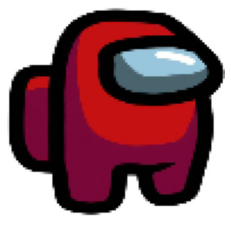

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def imshow(im):
    plt.imshow(im)
    plt.axis('off')

imshow(x[0])

## einops library

In [5]:
!pip install einops

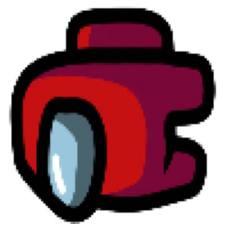

In [6]:
from einops import rearrange, reduce, repeat

# .transpose(1, 0, 2)

imshow(rearrange(x[0], 'h w c -> w h c'))

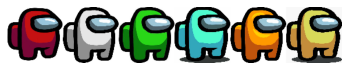

In [7]:
imshow(rearrange(x, "b h w c -> h (b w) c"))

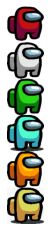

In [8]:
imshow(rearrange(x, "b h w c -> (b h) w c"))

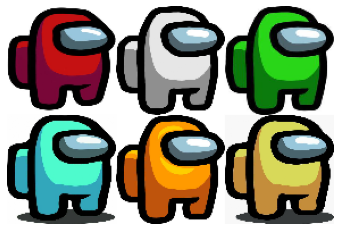

In [9]:
imshow(
    rearrange(x, '(b1 b2) h w c -> (b1 h) (b2 w) c ', b1=2)
)

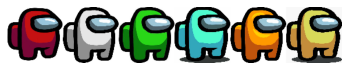

In [10]:
# rowwise

imshow(
    rearrange(x, '(b1 b2) h w c -> h (b1 b2 w) c ', b1=2)
)

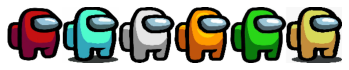

In [11]:
# colwise

imshow(
    rearrange(x, '(b1 b2) h w c -> h (b2 b1 w) c ', b1=2)
)

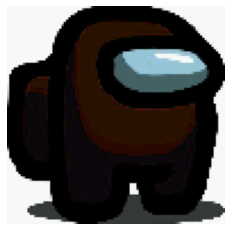

In [12]:
# reduce with agg. function, e.g. min, max, sum
# so we can replace .mean(dim=), etc.

imshow(
    reduce(x, 'b h w c -> h w c', 'min')
)

In [13]:
# torch.cat() from list

import torch

list_x = [torch.randn(64, 64, 3) for _ in range(6)]

rearrange(x, 'b h w c -> h w c b').shape

(96, 96, 3, 6)

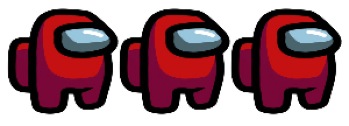

In [14]:
# repeat

imshow(
    repeat(x[0], 'h w c -> h (repeat w) c', repeat=3)
)

In [15]:
# unsqueeze

rearrange(x, 'b h w c -> 1 b h w c').shape

(1, 6, 96, 96, 3)

In [16]:
# squeeze

x_torch = torch.from_numpy(x)

rearrange(x_torch.unsqueeze(0), '1 b h w c -> b h w c').shape

torch.Size([6, 96, 96, 3])

In [17]:
# split into patches 16x16

imshow(
     rearrange(x[0], '(h p1) (w p2) c -> p1 (h w p2) c', p1 = 16, p2 = 16)
)

In [18]:
# example from MLP-Mixer
# Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),

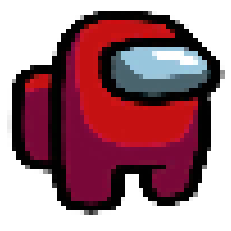

In [19]:
# MaxPool2d with k=(2,2)
imshow(
    reduce(x[0], '(h h1) (w w1) c -> h w c', reduction='max', h1=2, w1=2)
)

In [20]:
# we can use as torch layers

from torch.nn import Sequential, Conv2d, MaxPool2d, Linear, ReLU
from einops.layers.torch import Reduce, Rearrange

model = Sequential(
    Rearrange('b h w c -> b c h w'),
    Conv2d(3, 6, kernel_size=3, padding=1, stride=1),
    MaxPool2d(kernel_size=(2, 2)),
    Conv2d(6, 16, kernel_size=5, padding=0, stride=2),
    # combined pooling and flattening in a single step
    Reduce('b c (h 2) (w 2) -> b (c h w)', 'max'), 
    Linear(16*11*11, 120), 
    ReLU(),
    Linear(120, 10), 
)


In [21]:
x.shape, model(torch.from_numpy(x).float()).size()

((6, 96, 96, 3), torch.Size([6, 10]))

In [22]:
# parse shape of a tensor using pattern (returns dict)

from einops import parse_shape

parse_shape(x, 'b h w c')

{'b': 6, 'c': 3, 'h': 96, 'w': 96}